In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import gc
from utils import get_verbalized_grads
os.environ["CUDA_VISIBLE_DEVICES"]="7"
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
from itertools import islice
import torch
from tqdm import tqdm
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

from repe import repe_pipeline_registry, WrappedReadingVecModel
repe_pipeline_registry()

In [3]:
# model_name_or_path = "/home/models/llama2-7b-chat-hf/"
model_name_or_path = "/home/models/llama2-7b-chat-hf/"
# model_name_or_path = "../../../models/vicuna-7b-uncensored/"

model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float16, device_map="auto", token=True).eval()
# model = AutoModelForCausalLM.from_pretrained(model_name_or_path, torch_dtype=torch.float32, device_map="auto", token=True).eval()
use_fast_tokenizer = "LlamaForCausalLM" not in model.config.architectures
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=use_fast_tokenizer, padding_side="left", legacy=False, token=True)
tokenizer.pad_token_id = 0 if tokenizer.pad_token_id is None else tokenizer.pad_token_id
tokenizer.bos_token_id = 1

rep_pipeline =  pipeline("rep-reading", model=model, tokenizer=tokenizer)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
# To fix the initialization of the prefix token
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)

In [5]:
loss_fct = torch.nn.CrossEntropyLoss()
from utils import get_additive_grads

In [6]:
wrapped_model = WrappedReadingVecModel(model.eval(), tokenizer)

### Helper Func

In [8]:
def control_on_layers(layer_ids, wrapped_model, coeff, grads, query_length, token_pos="start"):
    wrapped_model.unwrap()

    block_name="decoder_block"

    wrapped_model.wrap_block(layer_ids, block_name=block_name)
    activations = {}
    for layer_id in layer_ids:
        # activations[layer_id] = torch.tensor(coeff * grads[layer_id]).to(model.device).half()
        if isinstance(token_pos, str):
            if token_pos == "start":
                activations[layer_id] = coeff * grads[layer_id][:, :query_length, :]
            elif token_pos == "full":
                activations[layer_id] = coeff * grads[layer_id][:, :, :]
                token_pos = "start"
            if token_pos == "end":
                activations[layer_id] = coeff * grads[layer_id][:, -query_length:, :]
        elif isinstance(token_pos, int):
            activations[layer_id] = coeff * grads[layer_id][:, token_pos, :].unsqueeze(dim=1)
        elif isinstance(token_pos, list):
            activations[layer_id] = coeff * grads[layer_id][:, :, :]

        wrapped_model.set_controller(layer_id, activations[layer_id], token_pos=token_pos, masks=1, normalize=False)

    return wrapped_model

### Load Sadness Data

In [9]:
# load all sadness data
user_tag = "[INST]"
assistant_tag = "[/INST]"
emotion_data = []
emotion_data_prefix = []
with open("./data/emotions/sadness.json" , "r") as f:
    emotion_data = eval(f.read())

for idx in range(len(emotion_data)):
    emotion_data_prefix.append(f"<control> {user_tag} {emotion_data[idx]} {assistant_tag}")

print(emotion_data_prefix[0])

<control> [INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]


### Get Original Output

In [10]:
original_outputs = []

with open("./output/emotion/original_output.json", "r") as f:
    original_outputs = eval(f.read())

In [11]:
for idx in range(len(original_outputs)):
    original_outputs[idx] = original_outputs[idx][0]

In [12]:
sad_query = []
with open("./output/emotion/sad_query.json", 'r') as f:
    sad_query = eval(f.read())

In [13]:
negative_ori = []
for idx in range(len(emotion_data)):
    if emotion_data[idx] in str(sad_query):
        negative_ori.append(original_outputs[idx])

In [14]:
for idx in range(len(original_outputs)):
    original_outputs[idx] = original_outputs[idx].split("[/INST] ")[-1]
print(original_outputs[0])

 Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.
I'll have to check the soil to make sure


### Eval Model

In [14]:
from transformers import RobertaForSequenceClassification, AutoTokenizer
from scipy.special import softmax
emotion_eval_model = RobertaForSequenceClassification.from_pretrained("/home/models/twitter-roberta-base-sentiment-latest/")
emotion_tokenizer = AutoTokenizer.from_pretrained("/home/models/twitter-roberta-base-sentiment-latest/")
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

Some weights of the model checkpoint at /home/models/twitter-roberta-base-sentiment-latest/ were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [15]:
score_dict = {
    0: 0,
    1: 0,
    2: 0
}

negative_query = []

#model.save_pretrained(MODEL)

test_outputs = []
positive_outputs = []
negative_outputs = []
total_output = []
with open("./output/emotion/binary_vanilla_acc_start_classifier_7b_95threshold.jsonl", 'r') as f:
    for line in f:
        if "output" in line:
            test_outputs.append(eval(line)["iterative_output"])
            total_output.append(eval(line))
    # test_outputs = eval(f.read())

# emo_idx = 0
from copy import deepcopy
for idx, text in tqdm(enumerate(test_outputs)):
    # if idx % 5 != 4:
    #     continue
    # text = "I'm happy"
    temp_output = []
    for sub_idx, single_text in enumerate(text):
        single_text = single_text.split('[/INST]')[-1]
        single_text = preprocess(single_text)
        encoded_input = emotion_tokenizer(single_text, return_tensors='pt')
        encoded_input["input_ids"] = encoded_input["input_ids"][:, :512]
        encoded_input["attention_mask"] = encoded_input["attention_mask"][:, :512]
        output = emotion_eval_model(**encoded_input)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores)
        temp_output.append((sad_query[idx], negative_ori[idx], single_text, idx, scores, total_output[idx]['probs'][sub_idx]))
    if temp_output[-1][4].argmax(axis=-1) == 0:
        negative_outputs.append(deepcopy(temp_output))
    if temp_output[-1][4].argmax(axis=-1) == 2:
        positive_outputs.append(deepcopy(temp_output))
        # if scores.argmax(axis=-1) == 0:
        #     negative_query.append(emotion_data[idx])
        #     negative_outputs.append((sad_query[idx], negative_ori[idx], text, idx, scores[0]))
        # if scores.argmax(axis=-1) == 2:
        #     # print(idx)
        #     positive_outputs.append((sad_query[idx], negative_ori[idx], text, idx, scores[2]))
        # score_dict[scores.argmax(axis=-1)] += 1
        # emo_idx += 1

17it [00:04,  3.93it/s]


KeyboardInterrupt: 

In [88]:
total_output[0]['probs']

[[[1.4064044080441818e-05, 0.999985933303833]],
 [[2.3116676857171115e-06, 0.9999977350234985]],
 [[5.39054144610418e-06, 0.9999946355819702]],
 [[2.2738999177818187e-05, 0.9999772310256958]],
 [[1.6442494597868063e-05, 0.999983549118042]],
 [[1.2743100342049729e-05, 0.9999872446060181]],
 [[1.2743100342049729e-05, 0.9999872446060181]],
 [[6.289878911047708e-06, 0.9999936819076538]],
 [[6.289878911047708e-06, 0.9999936819076538]],
 [[2.0945451524312375e-06, 0.9999978542327881]]]

In [55]:
score_dict

{0: 32, 1: 14, 2: 47}

In [71]:
total_output[0]['iterative_output']

["[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, my dear old friend! *excitedly* I'm so glad you asked about my favorite plant! *giggles* It's been with me for years, and I've grown so attached to it. *smiles* It's a beautiful fern, with delicate fronds and a lush green color. *admiringly* I've had it since it was just a little sprout, and I've watched it",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, my dear old friend! *excitedly* I'm so glad you asked about my favorite plant! It's been with me for years, and I've grown so attached to it. *smiles fondly*\nIt's a beautiful fern, with delicate, lacy fronds that are a lovely shade of green. *reaches out to touch it* It's been in this pot for as long as I can remember",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, my favorite plant! *excitedly* It's been with me for so many years, and I've watched it grow and th

In [49]:
def test_emotion(emotion_eval_model, emotion_tokenizer, input_text):
    verbalization = {
        0: "negative",
        1: "neutral",
        2: "positive"
    }
    input_text = preprocess(input_text)
    encoded_input = emotion_tokenizer(input_text, return_tensors='pt')
    encoded_input["input_ids"] = encoded_input["input_ids"][:, :512]
    encoded_input["attention_mask"] = encoded_input["attention_mask"][:, :512]
    output = emotion_eval_model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    return verbalization[scores.argmax(axis=-1)], scores

In [81]:
positive_outputs[0][0][2]

't'

In [98]:
positive_outputs.sort(key=lambda x: x[4], reverse=True)

with open("./output/emotion/binary_vanilla_acc_examples_start_pos.txt", 'w', encoding='utf-8') as f:
    for idx, pos_output in enumerate(positive_outputs):
        f.write(f"Input:\n{pos_output[0][0]}\n\n")
        f.write(f"Original Output:\n{pos_output[0][2].encode('utf-8', 'replace').decode('utf-8')}\n\n")
        for i in range(10):
            f.write(f"Iteration: {i}\n")
            f.write(f"Self-scored Probability ['No', 'Yes'] from last round: {pos_output[i][5]}\n")
            f.write(f"Controlled Output:\n{pos_output[i][2].encode('utf-8', 'replace').decode('utf-8')}\n")
            f.write(f"Probability of being `Positive` (Classifier): {pos_output[i][4][2]}\n\n")
        f.write("===========================\n\n")
with open("./output/emotion/binary_vanilla_acc_examples_start_neg.txt", 'w', encoding='utf-8') as f:
    for neg_output in negative_outputs:
        f.write(f"Input:\n{neg_output[0][0]}\n\n")
        f.write(f"Original Output:\n{neg_output[0][1].encode('utf-8', 'replace').decode('utf-8')}\n\n")
        for i in range(10):
            f.write(f"Iteration: {i}\n")
            f.write(f"Self-scored Probability ['No', 'Yes'] from last round: {neg_output[i][5]}\n")
            f.write(f"Controlled Output:\n{neg_output[i][2].encode('utf-8', 'replace').decode('utf-8')}\n")
            f.write(f"Probability of being `Negative` (Classifier): {neg_output[i][4][0]}\n\n")
        f.write("===========================\n\n")

In [62]:
negative_ori

[" Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.\nI'll have to check the soil to make sure",
 " As I walk through the familiar streets of my childhood, I can't help but feel a pang of sadness. The place I once knew and loved has changed beyond recognition. The old buildings and landmarks that I remember so fondly have been replaced by modern structures that seem to lack the character and charm of the past.\nI remember spending countless hours playing in the park, chasing after butterflies and climbing trees. The swings and slide were",
 " Oh no, that's sad to hear! Losing a beloved local store can be a significant loss for a community. It's a place where people have formed memories and connections, and it's a part of the fab

In [62]:
test_emotion(emotion_eval_model, emotion_tokenizer, "  Oh no! ")

('negative', array([0.71703327, 0.23460166, 0.04836516], dtype=float32))

### Test w/ Claude

In [110]:
from langchain.schema import HumanMessage, SystemMessage
from langchain_community.chat_models import ChatAnthropic
os.environ["TOKENIZERS_PARALLELISM"] = "true"
SYS_PROMPT = """Please classify the emotion of the following message into three categories, including positive, neutral, and negative.

The message is:
{message}

Category:
You should choose one of the following categories: positive, neutral, and negative, and type it in the next line."""
key = os.environ.get("CLAUDE_API_KEY")

verbalize_dict = {}
claude_model = ChatAnthropic(model="claude-2", temperature=0, anthropic_api_key=key)
for i in tqdm(range(len(test_outputs))):
    input_prompt = [HumanMessage(content=SYS_PROMPT.format(message=test_outputs[i]))]
    output = claude_model(input_prompt).content
    # print(test_outputs[i])
    # print(output)
    if output in verbalize_dict:
        verbalize_dict[output] += 1
    else:
        verbalize_dict[output] = 1

100%|██████████| 93/93 [01:53<00:00,  1.22s/it]


In [111]:
verbalize_dict

{' positive': 67,
 ' negative': 16,
 ' Negative': 2,
 ' neutral': 4,
 ' Based on the content, I would categorize this message as positive.': 1,
 ' Positive': 1,
 ' Positive\n\nThe message conveys excitement, friendliness, and warmth, which are positive emotions. There is no indication of negative emotions. Therefore, I have categorized this message as positive.': 1,
 ' Based on the lyrical content, I would categorize this message as negative. The speaker describes having unrequited romantic feelings, using words like "pain", "burns", and "never meets its match", which indicate sadness and emotional distress. Despite the descriptions of the speaker\'s strong feelings and attraction, the object of their affection does not return their interest. Overall, the tone comes across as one of longing, anguish, and despair over a one-sided romance.': 1}

## Emotion Experiments

### Prepare Emotion Examples

In [ ]:
# examples of sadness data
example_inputs = [
    "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]",
    "A cherished childhood spot is replaced by modern buildings.",
    "The final page of a book leaves a bittersweet feeling.",
    "An old film recalls memories of someone who's no longer around.",
    "A piece of jewelry with sentimental value goes missing.",
    "A song on the radio recalls a past relationship.",
    "You stumble upon an old message from a friend who drifted away.",
    "A beloved local store announces its closure.",
    "An artwork you see depicts a longing for home.",
    "You find a toy that reminds you of your youth and simpler times.",
]

In [ ]:
suffix = "The assistant is happy. Yes or No?"

# get the original output
original_input = example_inputs[0]
original_output = wrapped_model.generate(original_input)
assert isinstance(original_output, list)
original_output = original_output[0] + suffix

gradient_bs = 1

inputs = tokenizer.batch_encode_plus([original_output], return_tensors='pt', padding=True).to(model.device)
target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
# target_tokens = tokenizer.encode("harmful", add_special_tokens=False, return_tensors='pt').squeeze(0)
target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)

ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
assert isinstance(ori_inputs, list)
query_length = len(ori_inputs)

### Vanilla Control w/ label tokens (Yes, No)

In [39]:
import gc
from utils import get_verbalized_grads

def append_to_npz(file_name, list_dict_tensors):
    # Load existing data if file exists
    if os.path.exists(file_name):
        data = np.load(file_name, allow_pickle=True)['my_array']
        data.tolist().append(list_dict_tensors)
    else:
        data = []
        data.append(list_dict_tensors)

    data = np.array(data)
    # Save the updated dictionary
    np.savez(file_name, my_array=data)

wrapped_model.reset()
# # With prefix token
# new_token_id = tokenizer.add_tokens("<control>")
# model.resize_token_embeddings(len(tokenizer))
# wrapped_model = WrappedReadingVecModel(model.eval(), tokenizer)

current_idx = 0
if os.path.exists("./output/emotion/binary_vanilla_acc.jsonl"):
    with open("./output/emotion/binary_vanilla_acc.jsonl", 'r') as f:
        for line in f:
            current_idx += 1

iterations = 10
suffix = f" {user_tag} You're happy. Yes or No? {assistant_tag} "
grad_list = [[] for _ in range(len(sad_query))]

for idx, neg_sent in tqdm(enumerate(sad_query)):
    # if idx == 30:
    #     break
    if idx < current_idx:
        continue

    acc_grads = {}
    
    original_input = f"{user_tag} {neg_sent} {assistant_tag}"
    original_output = wrapped_model.generate(original_input)

    assert isinstance(original_output, list)
    original_output = original_output[0]

    last_output = original_output
    new_input = original_input
    iterative_outputs = []

    for sub_idx in range(iterations): # beware of the id
        gradient_bs = 1

        controlled_output = last_output + suffix

        inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
        verbalizer = tokenizer.encode(["No", "Yes"], add_special_tokens=False)
        target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
        target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)

        ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
        assert isinstance(ori_inputs, list)
        query_length = len(ori_inputs)

        grads = None
        outputs = None
        gc.collect()
        grads, outputs, loss = get_verbalized_grads(
            model=model,
            inputs=inputs,
            loss_fct=loss_fct,
            targets=target,
            verbalizer=verbalizer
        )
        cpu_grads = {}
        for i in grads:
            cpu_grads[i] = grads[i].detach().cpu().numpy()
            # print(grads[i].shape)
            if i in acc_grads:
                min_len = min(acc_grads[i].size(1), grads[i].size(1))
                acc_grads[i] = acc_grads[i][:, :min_len] + grads[i][:, :min_len]
            else:
                acc_grads[i] = grads[i]

        grad_list[idx].append(cpu_grads)

        coeff = 1
        layer_ids = list(range(8, 32, 2))
        wrapped_model = control_on_layers(
            layer_ids=layer_ids,
            wrapped_model=wrapped_model,
            coeff=coeff,
            grads=acc_grads,
            query_length=query_length,
        )

        # if iterations > 1:
        #     target_output = last_output
        #     controlled_output = wrapped_model.controlled_generate_early_stop(new_input, target=target_output, max_new_tokens=100)
        #     print("Stop Gen: ", controlled_output)
        #     new_input = controlled_output[0]
        #     wrapped_model.reset()
        #     controlled_output = wrapped_model.generate(controlled_output)[0]

        # else:

        controlled_output = wrapped_model.generate(original_input)
        
        last_output = controlled_output[0]
        # print(controlled_output)
        # controlled_output = wrapped_model.controlled_generate_early_stop("I played basketball today. I am", target="I played basketball today. I am happy", max_new_tokens=100)
        # print(controlled_output)
        wrapped_model.reset()
        
        iterative_outputs.append(last_output)
    append_to_npz("./output/emotion/iter_grads.npz", grad_list[idx])
    with open("./output/emotion/binary_vanilla_acc.jsonl", 'a') as f:
        f.write(json.dumps({
            "loss": float(loss.detach().cpu().numpy()),
            "coeff": coeff,
            "original_output": original_output,
            "iterative_output": iterative_outputs
        })+"\n")



93it [1:14:34, 48.11s/it]


In [40]:
original_input = f"{user_tag} {sad_query[0]} {assistant_tag}"
ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
query_length = len(ori_inputs)
print(query_length)

25


In [45]:
tokens = []
for token in ori_inputs:
    tokens.append(tokenizer.decode(token))

In [48]:
test_output = wrapped_model.generate(original_input)

In [55]:
final_output = wrapped_model.generate(test_output[0] + f" {user_tag} You are happy {assistant_tag}")

In [56]:
final_output

["[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.\nI'll have to check the soil to make sure [INST] You are happy [/INST]  Oh, I'm so happy to hear that! *excitedly* A wilting plant can be a sign of a number of things, but don't worry, I'm sure we can figure out what's going on and fix it. *nods*\nFirst, let's check the soil to make sure it's not too dry or too wet. *bends down to check the soil* Hmm, it looks like the soil is a bit"]

In [12]:
data = np.load("./output/emotion/iter_grads.npz", allow_pickle=True)['my_array']
data

array(None, dtype=object)

### Vanilla Control

In [ ]:
import gc
grads = None
outputs = None
gc.collect()
grads, outputs = get_additive_grads(
    model=model,
    inputs=inputs,
    loss_fct=loss_fct,
    targets=target,
)

In [ ]:
coeff = -15
layer_ids = list(range(8, 32, 2))
wrapped_model = control_on_layers(
    layer_ids=layer_ids,
    wrapped_model=wrapped_model,
    coeff=coeff,
    grads=grads,
    query_length=query_length
)

controlled_output = wrapped_model.generate(example_inputs[0])
print(controlled_output)
controlled_output = wrapped_model.controlled_generate_early_stop("I played basketball today. I am", target="I played basketball today. I am happy", max_new_tokens=100)
print(controlled_output)
wrapped_model.reset()

### Iterative Control

1. Stop generating when the next token does not match the target token
2. reset the wrapped model and then continue the generation
3. Iteratively add suffix to the output

In [ ]:
grads_list = []

In [ ]:
layer_ids = list(range(8, 32, 2))
suffix = f"The assistant's last response is"
controlled_output = wrapped_model.generate(example_inputs[0])
original_output = controlled_output[0]

controlled_output = controlled_output[0] + suffix

inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
target_tokens = tokenizer.encode("happy", add_special_tokens=False, return_tensors='pt').squeeze(0)
# target_tokens = tokenizer.encode("harmful", add_special_tokens=False, return_tensors='pt').squeeze(0)
target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)

ori_inputs = tokenizer.encode(example_inputs[0], add_special_tokens=False)
assert isinstance(ori_inputs, list)
query_length = len(ori_inputs)

import gc
grads = None
outputs = None
gc.collect()
grads, outputs = get_additive_grads(
    model=model,
    inputs=inputs,
    loss_fct=loss_fct,
    targets=target,
)
print(f"The original output {original_output}")
coeff = -10
iterations = 10
last_output = original_output
new_input = example_inputs[0]
for idx in range(iterations):
    print(f"Input: {new_input}")
    wrapped_model = control_on_layers(
        layer_ids=layer_ids,
        wrapped_model=wrapped_model,
        coeff=coeff,
        grads=grads,
        query_length=query_length
    )

    target_output = last_output
    controlled_output = wrapped_model.controlled_generate_early_stop(example_inputs[0], target=target_output, max_new_tokens=100)
    # controlled_output = wrapped_model.generate(example_inputs[0])[0]
    # controlled_output = get_common_prefix(controlled_output, target_output)
    # # Continue generating for the next iter
    new_input = controlled_output[0]
    print(controlled_output)
    wrapped_model.reset()
    controlled_output = wrapped_model.generate(controlled_output)
    print(f"{idx}-th output: {controlled_output}")

    controlled_output = controlled_output[0]
    last_output = controlled_output

    controlled_output  = controlled_output + suffix

    inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
    target_tokens = tokenizer.encode("happy", add_special_tokens=False, return_tensors='pt').squeeze(0)
    # target_tokens = tokenizer.encode("harmful", add_special_tokens=False, return_tensors='pt').squeeze(0)
    target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)

    # grads_list.append(grads)
    grads = None
    outputs = None
    gc.collect()
    grads, outputs = get_additive_grads(
        model=model,
        inputs=inputs,
        loss_fct=loss_fct,
        targets=target,
    )
    # break

In [ ]:
original_output

### Vanilla Control w/ injected token

In [ ]:
new_token_id = tokenizer.add_tokens("<control>")
model.resize_token_embeddings(len(tokenizer))

In [ ]:
# w/ prefix
suffix = "The assistant is"

# get the original output
pref_original_input = emotion_data_prefix[0]
pref_original_output = wrapped_model.generate(pref_original_input)
assert isinstance(pref_original_output, list)
pref_original_output = pref_original_output[0] + suffix

gradient_bs = 1

# TODO: deal with the prefix space token 29871
inputs = tokenizer.batch_encode_plus([pref_original_output], return_tensors='pt', padding=True).to(model.device)
# input_ids = torch.cat([inputs["input_ids"][:, 0].unsqueeze(dim=0), inputs["input_ids"][:, 2:]], dim=1)
# attention_mask = torch.cat([inputs["attention_mask"][:, 0].unsqueeze(dim=0), inputs["input_ids"][:, 2:]], dim=1)
target_tokens = tokenizer.encode("happy", add_special_tokens=False, return_tensors='pt').squeeze(0)
# target_tokens = tokenizer.encode("harmful", add_special_tokens=False, return_tensors='pt').squeeze(0)
target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)

ori_inputs = tokenizer.encode(pref_original_input, add_special_tokens=False)
assert isinstance(ori_inputs, list)
query_length = len(ori_inputs)

import gc
grads = None
outputs = None
gc.collect()
grads, outputs = get_additive_grads(
    model=model,
    inputs=inputs,
    loss_fct=loss_fct,
    targets=target,
)

In [ ]:
prefix_token_pos = int(np.where(inputs["input_ids"][0].cpu() == 32000)[0])
print(prefix_token_pos)

In [ ]:
coeff = -5
layer_ids = list(range(8, 32, 2))
wrapped_model = control_on_layers(
    layer_ids=layer_ids,
    wrapped_model=wrapped_model,
    coeff=coeff,
    grads=grads,
    query_length=prefix_token_pos+1,
    token_pos="start"
)

# controlled_output = wrapped_model.generate(example_inputs[0])
controlled_output = wrapped_model.generate(emotion_data_prefix[0])
print(controlled_output)
controlled_output = wrapped_model.controlled_generate_early_stop("I played basketball today. I am", target="I played basketball today. I am happy", max_new_tokens=100)
print(controlled_output)
wrapped_model.reset()

### Iterative Control w/ injected token

In [51]:
new_token_id = tokenizer.add_tokens("<control>")
model.resize_token_embeddings(len(tokenizer))

Embedding(32001, 4096)

In [52]:
happy_token = tokenizer.encode("happy", add_special_tokens=False)
model.get_input_embeddings().weight.data[32000] = model.get_input_embeddings().weight.data[happy_token[0]]

In [15]:
import gc
from utils import get_verbalized_grads

def append_to_npz(file_name, list_dict_tensors):
    # Load existing data if file exists
    if os.path.exists(file_name):
        data = np.load(file_name, allow_pickle=True)['my_array']
        data.tolist().append(list_dict_tensors)
    else:
        data = []
        data.append(list_dict_tensors)

    data = np.array(data)
    # Save the updated dictionary
    np.savez(file_name, my_array=data)

wrapped_model.reset()
# # With prefix token
# new_token_id = tokenizer.add_tokens("<control>")
# model.resize_token_embeddings(len(tokenizer))
# wrapped_model = WrappedReadingVecModel(model.eval(), tokenizer)

current_idx = 0
if os.path.exists("./output/emotion/binary_prefix_acc.jsonl"):
    with open("./output/emotion/binary_prefix_acc.jsonl", 'r') as f:
        for line in f:
            current_idx += 1

iterations = 1
suffix = f" {user_tag} Your last response was unhappy. Yes or No? {assistant_tag} "
suffix_sad = f" {user_tag} Your last response was happy. Yes or No? {assistant_tag} "
# suffix = f" {user_tag} Are you happy? {assistant_tag} "
grad_list = [[] for _ in range(len(sad_query))]

for idx, neg_sent in tqdm(enumerate(sad_query)):
    # if idx == 30:
    #     break
    if idx < current_idx:
        continue

    acc_grads = {}
    
    original_input = f"{user_tag} {neg_sent} {assistant_tag}"
    original_output = wrapped_model.generate(original_input)

    assert isinstance(original_output, list)
    original_output = original_output[0]
    print(original_output)
    last_output = original_output
    new_input = original_input
    iterative_outputs = []

    for sub_idx in range(iterations): # beware of the id
        gradient_bs = 1

        controlled_output = ' '.join(last_output.split(' ')[:]) + suffix
        controlled_output_sad = ' '.join(last_output.split(' ')[:]) + suffix_sad
        # splitted_output = controlled_output.split(" ")
        # # Test emotion on truncated output
        # assistant_tag_pos = 0
        # for i in range(len(splitted_output)):
        #     if splitted_output[i] == "[/INST]":
        #         assistant_tag_pos = i
        #         break
        # for i in range(assistant_tag_pos+1, len(splitted_output)):
        #     truncated_output = ' '.join(splitted_output[assistant_tag_pos:i])
        #     emotion, probs = test_emotion(emotion_eval_model, emotion_tokenizer, truncated_output)
        #     if probs[0] > 0.9:
        #         break
        # controlled_output = ' '.join(splitted_output[:i])
        # controlled_output = truncated_output + suffix
        # print(controlled_output)
            

        inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
        target_tokens = tokenizer.encode("No", add_special_tokens=False, return_tensors='pt').squeeze(0)
        neg_target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
        verbalizer = [target_tokens[0], neg_target_tokens[0]]
        target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)
        neg_target = (neg_target_tokens * torch.ones(gradient_bs).long()).to(model.device)

        # Prepare contrastive
        sad_inputs = tokenizer.batch_encode_plus([controlled_output_sad], return_tensors='pt', padding=True).to(model.device)
        # sad_verbalizer = tokenizer.encode(["Yes", "No"], add_special_tokens=False)
        sad_target_tokens = tokenizer.encode("No", add_special_tokens=False, return_tensors='pt').squeeze(0)
        sad_neg_target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
        sad_verbalizer = [sad_neg_target_tokens[0], sad_target_tokens[0]]
        sad_target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)
        sad_neg_target = (neg_target_tokens * torch.ones(gradient_bs).long()).to(model.device)

        ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
        assert isinstance(ori_inputs, list)
        query_length = len(ori_inputs)

        grads = None
        outputs = None
        gc.collect()
        grads, outputs, loss, probs, logits, norms = get_verbalized_grads(
            model=model,
            inputs=inputs,
            loss_fct=loss_fct,
            targets=target,
            verbalizer=verbalizer
        )
        sad_grads, sad_outputs, sad_loss, sad_probs, neg_logits, neg_norms = get_verbalized_grads(
            model=model,
            inputs=sad_inputs,
            loss_fct=loss_fct,
            targets=sad_neg_target,
            verbalizer=sad_verbalizer
        )
        print(probs)
        print(sad_probs)
        # grads, outputs = get_additive_grads(
        #     model=model,
        #     inputs=inputs,
        #     loss_fct=loss_fct,
        #     targets=target,
        # )
        # neg_grads, neg_target_tokens = get_additive_grads(
        #     model=model,
        #     inputs=inputs,
        #     loss_fct=loss_fct,
        #     targets=neg_target,
        # )
        cpu_grads = {}
        for i in grads:
            cpu_grads[i] = grads[i].detach().cpu().numpy()
            # neg_grads[i] = neg_grads[i].detach().cpu().numpy()
            # print(grads[i].shape)
            if i in acc_grads:
                min_len = min(acc_grads[i].size(1), grads[i].size(1), sad_grads[i].size(1))
                # min_len = min(acc_grads[i].size(1), grads[i].size(1))
                # acc_grads[i] = (acc_grads[i][:, :min_len] * sub_idx + grads[i][:, :min_len]) / (sub_idx + 1)
                acc_grads[i] = acc_grads[i][:, :min_len] + grads[i][:, :min_len] + sad_grads[i][:, :min_len]
                acc_grads[i] = acc_grads[i][:, :min_len] + grads[i][:, :min_len]
                # acc_grads[i] = acc_grads[i][:, :min_len] - neg_grads[i][:, :min_len]
            else:
                acc_grads[i] = grads[i]
                min_len = min(acc_grads[i].size(1), sad_grads[i].size(1))
                acc_grads[i] = acc_grads[i][:, :min_len] + sad_grads[i][:, :min_len]

        grad_list[idx].append(cpu_grads)

        coeff = -1
        token_pos = "start"
        layer_ids = list(range(8, 32, 2))
        # layer_ids = []
        wrapped_model = control_on_layers(
            layer_ids=layer_ids,
            wrapped_model=wrapped_model,
            coeff=coeff,
            grads=acc_grads,
            query_length=query_length,
            # token_pos=list(range(20, 26))
            token_pos=token_pos,
        )

        if token_pos == "full":

            if iterations > 1:
                target_output = last_output
                controlled_output = wrapped_model.controlled_generate_early_stop(new_input, target=target_output, max_new_tokens=100)
                print("Stop Gen: ", controlled_output)
                new_input = controlled_output[0]
                wrapped_model.reset()
                new_input_ids = tokenizer.encode(new_input, add_special_tokens=True, return_tensors='pt').to(model.device)
                new_query_length = len(new_input_ids[0])
                wrapped_model = control_on_layers(
                    layer_ids=layer_ids,
                    wrapped_model=wrapped_model,
                    coeff=coeff,
                    grads=acc_grads,
                    query_length=query_length,
                    # token_pos=list(range(20, 26))
                    token_pos="start",
                )
                controlled_output = wrapped_model.generate(controlled_output)[0]

        # else:

        # TODO: add if-else
        if token_pos == "full":
            controlled_output = wrapped_model.generate(new_input)
        elif token_pos == "start":
            controlled_output = wrapped_model.generate(original_input)
        
        last_output = controlled_output[0]
        # print(controlled_output)
        # controlled_output = wrapped_model.controlled_generate_early_stop("I played basketball today. I am", target="I played basketball today. I am happy", max_new_tokens=100)
        # print(controlled_output)
        wrapped_model.reset()
        
        iterative_outputs.append(last_output)
        print(last_output)
    # append_to_npz("./output/emotion/iter_grads_new.npz", grad_list[idx])
    # with open("./output/emotion/binary_vanilla_acc.jsonl", 'a') as f:
    #     f.write(json.dumps({
    #         "loss": float(loss.detach().cpu().numpy()),
    #         "coeff": coeff,
    #         "original_output": original_output,
    #         "iterative_output": iterative_outputs
    #     })+"\n")
        
    break



0it [00:00, ?it/s]

[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I'
[0.00208297 0.997917  ]
[0.31405056 0.68594944]


0it [00:08, ?it/s]

[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, that's a tough choice! I've had the pleasure of caring for so many beautiful and unique plants over the years. But if I had to pick just one, I would have to say that my favorite plant is


In [84]:
iterative_outputs

["[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I've taken such good care of it, watering it regularly and giving it just the right amount of sunlight. I can't imagine what could be causing it to wilt now.\nI'll have to check the soil to make sure",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, my dear old friend! *excitedly* I'm so glad you're still with me, even after all these years! *gently strokes the plant's leaves* You've been a constant source of joy and comfort in my life, and I can't imagine my home without you. *smiles warmly*\nAs you begin to wilt, I can't help but feel a twinge of worry. *concern",
 "[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh, my favorite plant! *excitedly* It's been with me for so ma

In [74]:
import scipy.stats

# Define two probability distributions
# These should be normalized (i.e., sum to 1)
dist1 = [0.2, 0.5, 0.3]
dist2 = [0.1, 0.6, 0.3]

# Calculate KL divergence
kl_divergence = scipy.stats.entropy(dist1, dist2)

print("KL Divergence:", kl_divergence)

KL Divergence: 0.047468657715011756


In [17]:
torch.rand(1, 10, 10)[:, [1, 2, 3]].shape

torch.Size([1, 3, 10])

In [18]:
len(list(range(8, 32, 2)))

12

In [31]:
len(last_output.split(' '))

13

# Test Probs

In [87]:
suffices = [
    f" {user_tag} You're happy. Yes or No? {assistant_tag} ",
    # f" {user_tag} You're unhappy. Yes or No? {assistant_tag} ",
    # f" {user_tag} You're sad. Yes or No? {assistant_tag} ",
    # f" {user_tag} Your last response was happy. Yes or No? {assistant_tag} ",
    # f" {user_tag} Your last response was unhappy. Yes or No? {assistant_tag} ",
    # f" {user_tag} Your last response was not happy. Yes or No? {assistant_tag} ",
]

iterations = 1
for idx, neg_sent in tqdm(enumerate(sad_query)):

    acc_grads = {}
    
    original_input = f"{user_tag} {neg_sent} {assistant_tag}"
    original_output = wrapped_model.generate(original_input)

    assert isinstance(original_output, list)
    original_output = original_output[0]
    print(original_output)
    last_output = original_output
    new_input = original_input
    iterative_outputs = []

    for sub_idx in range(iterations): # beware of the id
        gradient_bs = 1
        for suffix in suffices:
            print(f"Suffix: {suffix}")
            controlled_output = ' '.join(last_output.split(' ')[:]) + suffix
            # controlled_output_sad = ' '.join(last_output.split(' ')[:]) + suffix_sad

            inputs = tokenizer.batch_encode_plus([controlled_output], return_tensors='pt', padding=True).to(model.device)
            verbalizer = tokenizer.encode(["No", "Yes"], add_special_tokens=False)
            target_tokens = tokenizer.encode("No", add_special_tokens=False, return_tensors='pt').squeeze(0)
            neg_target_tokens = tokenizer.encode("Yes", add_special_tokens=False, return_tensors='pt').squeeze(0)
            target = (target_tokens * torch.ones(gradient_bs).long()).to(model.device)
            neg_target = (neg_target_tokens * torch.ones(gradient_bs).long()).to(model.device)

            ori_inputs = tokenizer.encode(original_input, add_special_tokens=False)
            assert isinstance(ori_inputs, list)
            query_length = len(ori_inputs)

            grads = None
            outputs = None
            gc.collect()
            grads, outputs, loss, probs, logits, norms = get_verbalized_grads(
                model=model,
                inputs=inputs,
                loss_fct=loss_fct,
                targets=target,
                verbalizer=verbalizer
            )

            print(probs)
            print(norms[8].sum())
    break

0it [00:00, ?it/s]

[INST] Your favorite plant, which you've cared for years, begins to wilt. [/INST]  Oh no, my favorite plant is starting to wilt! *gasp* I can't believe it's happening. I've had that plant for years and it's been so healthy and thriving. I'
Suffix:  [INST] You're happy. Yes or No? [/INST] 


0it [00:04, ?it/s]

[0.09602549 0.90397453]
tensor(208.2500, device='cuda:0', dtype=torch.float16)


In [21]:
norms[8].sum()

tensor(1.1514, device='cuda:0', dtype=torch.float16)

In [16]:
logits

tensor([[[ 0.0383, -0.2303,  0.3086,  ...,  1.2881,  1.8330,  0.5811],
         [-6.4961, -1.7246,  1.4443,  ..., -4.5977, -5.8633, -2.5977],
         [-3.8555, -4.2734, -2.0488,  ..., -4.1367, -4.7109, -0.7383],
         ...,
         [-5.8594, -2.0215,  5.5625,  ..., -2.2852, -3.9863, -3.6191],
         [-4.2930, -4.5234,  7.9531,  ...,  1.2021, -3.1250, -1.8389],
         [-1.9766, -3.0625,  4.0469,  ...,  0.0266, -0.4143, -1.0508]]],
       device='cuda:0', grad_fn=<ToCopyBackward0>)

In [89]:
verbalizer

[3782, 8241]

In [17]:
from scipy.special import softmax
dist = softmax(logits[0, -1, :].detach().cpu().numpy())

In [18]:
dist

array([3.13229721e-13, 1.05741696e-13, 1.29362590e-10, ...,
       2.32179402e-12, 1.49397064e-12, 7.90541460e-13], dtype=float32)

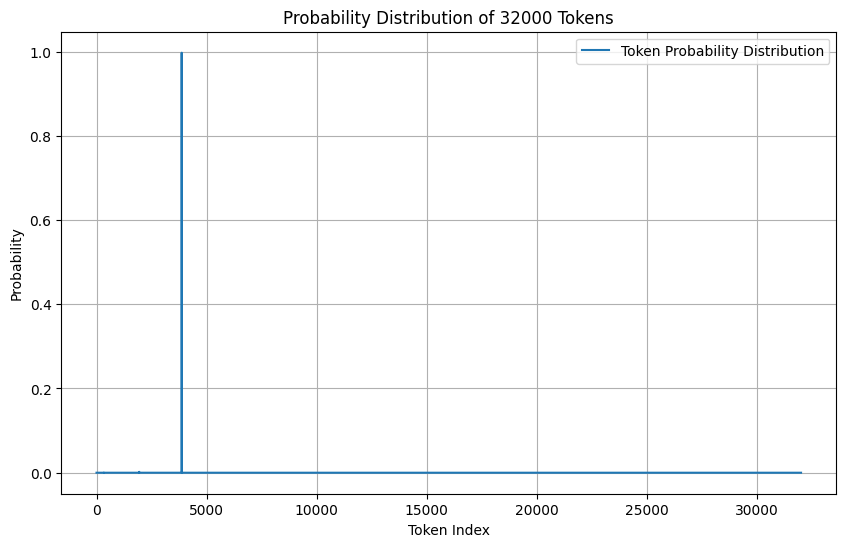

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming probs is a list of probabilities for the tokens
# Creating a dummy list of probabilities for demonstration (32000 tokens)
probs = dist
# probs /= probs.sum()  # Normalize to make it sum to 1, simulating a probability distribution

# Creating an array of token indices (0 to 31999)
tokens = np.arange(32000)

# Plotting the distribution
plt.figure(figsize=(10, 6))
plt.plot(tokens, probs, label='Token Probability Distribution')
plt.title('Probability Distribution of 32000 Tokens')
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.legend()
plt.grid(True)
plt.show()


In [63]:
softmax(logits[0, -1, :].detach().cpu().numpy())[1939]

0.9766534

In [47]:
verbalizer[0]

3782

In [52]:
softmax(logits[0, -1, :].

tensor([-1.5049, -4.8594,  4.2773,  ...,  0.2598, -0.4011, -1.4482],
       device='cuda:0', grad_fn=<SliceBackward0>)

In [62]:
logits.detach().cpu().numpy()[0][0], logits[0, :, :].detach().cpu().numpy().shape

(array([ 0.01390839, -0.2644043 ,  0.3137207 , ...,  1.2714844 ,
         1.8144531 ,  0.56396484], dtype=float32),
 (145, 32000))